# Prévisions météorologiques en Australie

# Modélisation avec étape de ré-échantillonage

# Récupération des librairies

In [1]:
# récupération du package skater
# SUR UN TERMINAL: "conda install -c conda-forge Skater"

In [2]:
# récupération du package imblearn
!pip install --upgrade imblearn

In [3]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time, datetime
import warnings
warnings.filterwarnings("ignore")

from skater.core.explanations import Interpretation
from sklearn.metrics import classification_report
from skater.model import InMemoryModel
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

# Modèle de classification par apprentissage supervisé

### Préparation du jeu de données et paramètrage

In [4]:
# récuperation et aperçu du jeu de données après prétraitement des données, après l'étape de classification des villes 
# en fonction du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [5]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [6]:
# division des données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=123)

In [7]:
# undersampling des données
rUs = RandomUnderSampler()
X_train, y_train = rUs.fit_resample(X_train, y_train)

In [8]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible ré-échantillonnée:", dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible ré-échantillonnée: {0: 21854, 1: 21854}


In [9]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [10]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 32890, 1: 9347}


In [11]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.778701
1    0.221299
Name: RainTomorrow, dtype: float64

In [12]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Séparateurs à Vaste Marge (SVM)

Les séparateurs à vaste marge (SVM) visent à résoudre les problèmes de classification en trouvant de bonnes frontières de décision entre deux ensembles de points appartenant à deux catégories différentes. Une frontière de décision peut être considérée comme une ligne ou une surface séparant les données d’apprentissage en deux demi-espaces correspondant à deux catégories de prédiction, soit dans le cadre de notre étude `"RainTomorrow=0"` et `"RainTomorrow=1"`. Pour classer de nouveaux points de données, il suffit de vérifier de quel côté de la frontière de décision ils se trouvent.

Les séparateurs à vaste marge procèdent à la recherche de ces frontières en deux étapes :
- Les données sont mises en correspondance avec une nouvelle représentation à haute dimension où la frontière de décision peut être exprimée sous la forme d’un hyperplan.
- Le séparateur à vaste marge identifie l'hyperplan qui maximise la distance au point le plus proche dans chaque classe. Cela permet à la frontière de bien s’adapter à de nouveaux échantillons en dehors de l’ensemble de données d’apprentissage.

La méthode de classification par SVM ne fournit pas directement de probabilités d'appartenir à chaque classe mais les classes prédites elle-mêmes en fonction du score qu'elle attribue à chaque individu.  

In [13]:
# définition du modèle
clf_svm = SVC(probability=True, C=1.0, class_weight={0:0.52, 1:0.48}, gamma=1.0, kernel='rbf')

# entraînement du modèle
clf_svm.fit(X_train_scaled, y_train)

SVC(class_weight={0: 0.52, 1: 0.48}, gamma=1.0, probability=True)

In [14]:
# prédictions du modèle à l'aide d'un seuil de probabilités adapté pour mieux distinguer les classes
y_probas_test = clf_svm.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= 0.495).astype(bool)

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(clf_svm.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(clf_svm.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification 
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Train Data Score: 0.8609407888716024
Test Data Score: 0.791320406278855

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25785  7105
1             1977  7370

               precision    recall  f1-score   support

           0       0.93      0.78      0.85     32890
           1       0.51      0.79      0.62      9347

    accuracy                           0.78     42237
   macro avg       0.72      0.79      0.73     42237
weighted avg       0.84      0.78      0.80     42237


                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.78      0.79      0.85      0.79      0.62     32890
          1       0.51      0.79      0.78      0.62      0.79      0.62      9347

avg / total       0.84      0.78      0.79      0.80      0.79      0.62     42237



- `0.78 < accuracy, sensibilité, spécificité, moyenne géométrique = 0.79`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.62`
- `f1-macro = 0.73`

### Interprétation du modèle avec Skater

In [24]:
# conversion de l'ensemble d'entraînement standardisé en DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [25]:
# création d'un modèle
model = InMemoryModel(clf_svm.predict_proba, examples=X_train_scaled)

In [26]:
# création d'une interprétation
interpreter = Interpretation(X_train_scaled, feature_names=X_train_scaled.columns)

In [27]:
# création d'un objet DataSet à partir des entrées, lié à l'interprétation
interpreter.load_data(X_train_scaled)

[13/13] features ████████████████████ Time elapsed: 2131 seconds

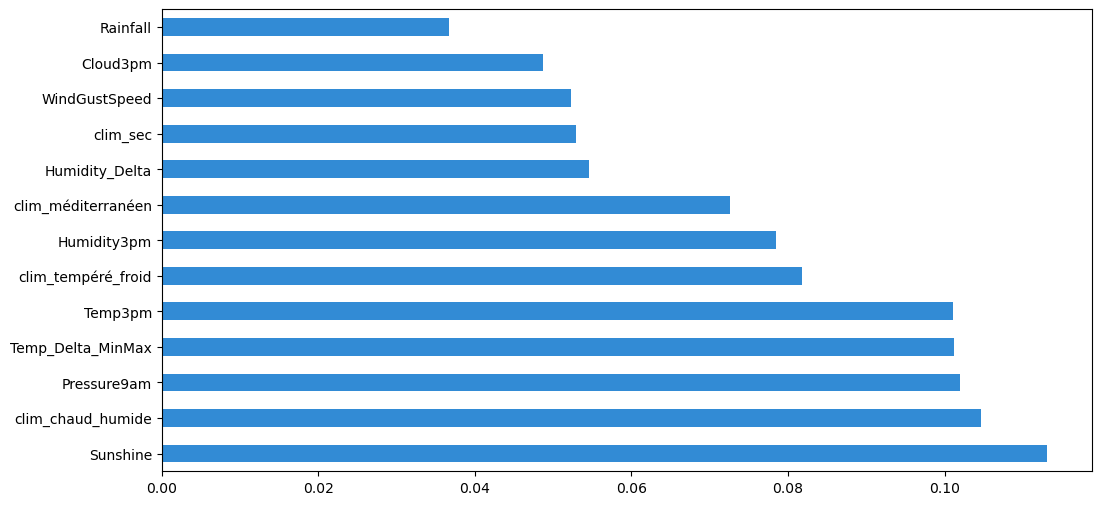

In [28]:
# affichage de l'importance des variables dans le jeu de données
plt.rcParams['figure.figsize'] = (12,6)
interpreter.feature_importance.plot_feature_importance(model, ascending=True);

Nous affichons ci-dessous les graphiques de dépendance partielle des variables ayant le plus d'importance pour mesurer individuellement leur impact sur la prédiction du modèle, lorsque les autres variables sont maintenues constantes. 

La dérivée de la dépendance partielle permet de décrire l'impact de chaque variable.

[69/69] grid cells ████████████████████ Time elapsed: 39 seconds

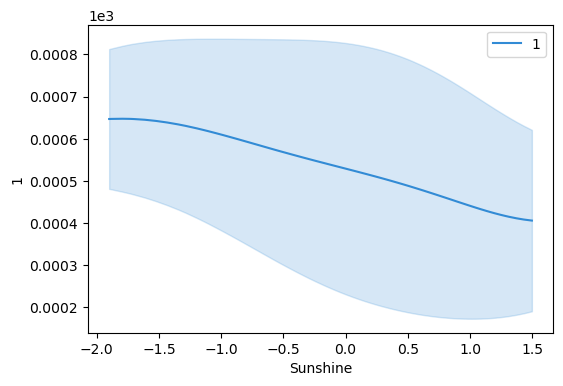

In [20]:
# affichage du graphique de dépendance partielle de la variable "Sunshine"
interpreter.partial_dependence.plot_partial_dependence(
    ['Sunshine'], model, grid_resolution=100, with_variance=True, figsize=(6,4));

Plus l'ensoleillement est faible, plus il est probable qu'il pleuve le lendemain.

[100/100] grid cells ████████████████████ Time elapsed: 62 seconds

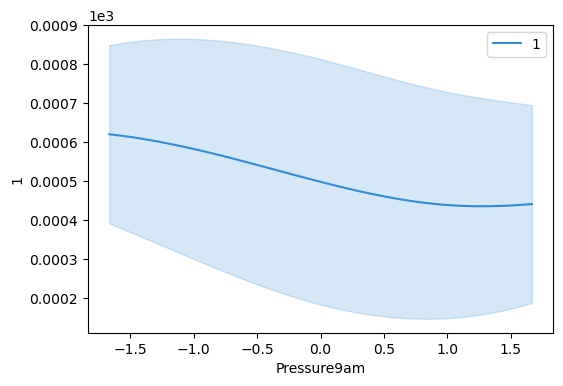

In [21]:
# affichage du graphique de dépendance partielle de la variable "Pressure9am"
interpreter.partial_dependence.plot_partial_dependence(
    ['Pressure9am'], model, grid_resolution=100, with_variance=True, figsize=(6,4));

Plus la pression est faible à 9h, plus il est probable qu'il pleuve le lendemain.